# Task and Data Analysis

#### Overview of the Data

The dataset consists of product reviews from Amazon, segmented into features with annotated sentiment scores. Reviews include multiple aspects such as ease of use, picture quality, and additional functionalities, each tagged with a corresponding sentiment score. These annotations provide a rich basis for sentiment analysis but require precise parsing to effectively utilize the structured format in which they are presented.

#### System-Level Outline

##### Data Parsing and Pre-processing

Using a custom `read_file` function, the system initially parses the structured reviews from text files. This function handles the dataset's specific format, which includes initial metadata and reviewer comments split by a unique delimiter ('##'). This is crucial for separating feature tags from review content, facilitating subsequent analysis.

The `pre_process_review` function further refines this by extracting titles and adjusting reviews accordingly, ensuring that the context provided by review headers is not lost. Additionally, it preserves the integrity of the review flow, which is vital for understanding the nuances of each review.

##### Enhancing NLP with Custom Processing

To deepen the analysis, the `preserve_compound_phrases` function is employed. This function utilizes an NLP model to identify and preserve compound nouns and adjectives directly linked to nouns, which are often critical in understanding the specific features discussed. By preserving these compounds, the system maintains the granular detail necessary for precise feature extraction.

Following this, the `chunking_post_process` method reassembles the text from tokenized forms back into a structured format conducive to further analysis, ensuring that compound phrases are treated as single entities within the dataset.

##### Comprehensive Review Filtering

The `pre_processing_controller` function orchestrates the entire preprocessing pipeline. It transforms raw review texts into a tokenized format, applies compound preservation, and executes two levels of filtering: soft filtering (preserving basic structure and some stopwords) and hard filtering (removing all non-alphabetic characters and stopwords). This dual approach allows for flexibility in analysis, from high-level sentiment trends to detailed feature-specific sentiments.

##### Sentiment Analysis and Feature Extraction

Once preprocessed, the data is ripe for sentiment analysis. Leveraging the structured format of feature tags and sentiment scores, the system can map sentiments directly to product features, allowing for an aggregated sentiment score for each feature. This quantification is pivotal in determining which features are most appreciated or criticized by users.

##### Leveraging Data for Business Insights

The final step involves synthesizing the analyzed data into actionable business insights. By understanding which features correlate strongly with positive or negative sentiments, companies can prioritize product improvements or highlight successful aspects in marketing strategies.

In [1]:
import pandas as pd
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import re
import copy

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load('en_core_web_lg') 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
Word2Vec_corpus = api.load('text8') 
Word2Vec_model = Word2Vec(Word2Vec_corpus) 
glove_model = api.load("glove-twitter-25") 
sentiment_intensity_analyser = SentimentIntensityAnalyzer()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /Users/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
files = ['Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt',
         'Data/Customer_review_data/Canon G3.txt',
         'Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
         'Data/Customer_review_data/Nikon coolpix 4300.txt',
         'Data/Customer_review_data/Nokia 6610.txt',
         'Data/CustomerReviews-3_domains/Computer.txt',
         'Data/CustomerReviews-3_domains/Router.txt',
         'Data/CustomerReviews-3_domains/Speaker.txt',
         'Data/Reviews-9-products/Canon PowerShot SD500.txt',
         'Data/Reviews-9-products/Canon S100.txt',
         'Data/Reviews-9-products/Diaper Champ.txt',
         'Data/Reviews-9-products/Hitachi router.txt',
         'Data/Reviews-9-products/ipod.txt',
         'Data/Reviews-9-products/Linksys Router.txt',
         'Data/Reviews-9-products/MicroMP3.txt',
         'Data/Reviews-9-products/Nokia 6600.txt',
         'Data/Reviews-9-products/norton.txt']

sample_file_list = [files[1], files[2], files[11]]

### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Data Pre-Processing

### Data Ingestion and Initial Processing

The process starts with the ingestion of data files containing multiple reviews, which can vary in structure. This step is crucial for setting the stage for detailed analysis. The function `read_file` is used to open and read the contents of these files. Reviews are often separated by new lines and may begin with a distinctive line of asterisks, which indicates metadata or headers not part of the actual review content. These non-relevant lines are programmatically identified and omitted from processing to ensure only pertinent text is analyzed further.

The reviews within these files are then split using '##' as a delimiter. This segmentation is critical as it separates tags that contain embedded metadata or sentiment scores from the main content. Each segment of the review, along with its associated tags, is stored in a structured format within a pandas DataFrame, which facilitates ease of manipulation and detailed analysis in subsequent steps.

### Advanced Text Processing Techniques

Once the initial data ingestion is complete, the reviews undergo various text processing steps encapsulated within the `pre_process_review` function. This function is adept at managing different nuances of text, such as concatenating titles where necessary, and ensuring the textual integrity of reviews that span multiple lines is maintained.

### Preservation of Semantic Structures

To maintain the semantic integrity of phrases within the reviews, the `preserve_compound_phrases` function is employed. This function utilizes spaCy, an advanced NLP library, to parse the text and identify compound nouns and adjectival modifiers. These elements are crucial for understanding the context and sentiment related to specific product features. The identified compounds are then reconstructed with underscores replacing spaces, ensuring they are treated as single tokens in subsequent analysis stages. This preservation prevents the loss of semantic unity and is vital for the accurate interpretation of product features.

### Enhancement of Tokenization and Filtering

Following the preservation of semantic structures, the `pre_processing_controller` function orchestrates several layers of tokenization and filtering. The text is initially tokenized, which separates each word or phrase for individual analysis. This tokenization process feeds into a dual filtering system:

1. A 'Soft Filtered Review' captures tokens that either are part of the identified compound phrases or are standalone alphabetic words. This layer ensures that important phrases and words are retained without too much reduction of the text.
2. A 'Filtered Review' applies a more stringent filter that includes the removal of common stop words, focusing only on the more meaningful terms relevant to sentiment analysis. This selective filtering is crucial for reducing noise and enhancing the focus on significant textual elements.

These tokens are then reassembled into coherent strings, which form the basis for deeper linguistic analysis, such as lemmatization. The 'Soft Filtered Review' is transformed back into a string format while retaining the structural integrity of compound phrases. Lemmatization is performed on the 'Filtered Review' strings to reduce words to their base or dictionary form, which facilitates a more generalized but robust analysis of text data.

In [3]:
def read_file(file_path):
    
    tagged_reviews = []
    
    with open(file_path, 'r') as file:
        text = file.read()
        # Split the text into lines and remove any leading/trailing whitespace
        reviews = text.strip().split('\n')

        # Check if the file starts with a specific marker line of asterisks
        if reviews[0] == '*' * 77:
            # Skip the first 11 lines if the marker is present - This is a quirk to parse the data files
            reviews = reviews[11:]

        reviews = hanldle_titles(reviews)
        
        for review in reviews:
            # Split each review on '##' to separate tags from the content
            parts = review.split('##')
            
            # If the split results in more than one part, process tags and content
            if len(parts) > 1:
                tags = parts[0].strip().split(',')
                content = parts[1].strip() 
            else:
                # If no '##' is found, set tags as empty and set content to the whole line
                tags = []
                content = parts
                
            # Append a dictionary of tags and review content to the list
            tagged_reviews.append({'Tags': tags, 'Review': content})

        df = pd.DataFrame(tagged_reviews)
        # Store the name of the file as an attribute of the DataFrame
        df.attrs['title'] = file_path.split('/')[-1]

        return df


def hanldle_titles(reviews):
    processed_reviews = []
    title_switch = False  # Indicates whether next review should append a title
    title = ''

    for review in reviews:
        if review.startswith('[t]'):  # Checks for title marker
            title = review[3:]  # Stores the title
            title_switch = True
        elif title_switch:  # Appends title to the review if flag is true
            processed_reviews.append(review + title)
            title_switch = False
            title = ''
        else:
            processed_reviews.append(review)  # Adds review as is if no title is pending

    return processed_reviews


In [4]:
def preserve_compound_phrases(text):
    # Process the text with an NLP model
    doc = nlp(text)
    processed_tokens = []

    for token in doc:
        # Check for compounds or adjectives linked directly to nouns
        if token.dep_ in ('compound', 'amod') and token.head.pos_ == 'NOUN':
            compound_phrase = f"{token.text}_{token.head.text}"
            if compound_phrase not in processed_tokens:
                processed_tokens.append(compound_phrase)
        # Skip nouns that are already part of a compound to prevent duplicates
        elif token.pos_ == 'NOUN' and any(child.dep_ == 'compound' for child in token.children):
            continue
        # Include all other tokens normally
        else:
            processed_tokens.append(token.text)

    return processed_tokens



def chunking_post_process(text):
    # Split the text into individual words
    words = text.split()
    processed_words = []

    i = 0
    while i < len(words):
        # Check if the current word is part of a compound phrase
        
        if '_' in words[i]:
            # Append all parts of the compound phrase to the list
            while i < len(words) and '_' in words[i]:
                processed_words.append(words[i])
                i += 1
            continue  # Move to the next word after finishing the compound phrase
        # Append non-compound words directly to the list
        processed_words.append(words[i])
        i += 1

    # Return the processed words as a single string
    return ' '.join(processed_words)

In [ ]:
def pre_processing_controller(df):
    
    # Convert lists to strings and applies compound phrase preservation
    df['Tokenised_Review'] = df['Review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    df['Tokenised_Review'] = df['Tokenised_Review'].apply(lambda review: preserve_compound_phrases(review))
    
    # Filters the reviews. Handling compound phrases, capitalisation and numbers 
    df['Soft_Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower())])
    
    # Convert lists of tokens back to strings and retains the compound phrases - soft means not to filter out stop words
    df['Soft_Filtered_Review_String'] = df['Soft_Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
    df['Soft_Filtered_Review_String'] = df['Soft_Filtered_Review_String'].apply(chunking_post_process)
    
    # Filters the reviews. Handling compound phrases, capitalisation, numbers and stop words 
    df['Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower() not in stop_words)])
    df['Filtered_Review_String'] = df['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
    
    # Lemmatise the filtered review strings
    df['Lemmatised_Review_String'] = df['Filtered_Review_String'].apply(lambda review_string: " ".join([token.lemma_ for token in nlp(review_string)]))
    df['Lemmatised_Tokenised_Filtered_Review'] = df['Filtered_Review_String'].apply(lambda review: word_tokenize(review))
    
    return df

### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Product Feature Extraction


1. **POS Noun Tagging:** Initially, the `POS_Noun_Tagging` function processes textual data from a DataFrame to extract nouns using part-of-speech (POS) tagging. This function tokenizes each text string, tags each token with its grammatical role, and filters out tokens that are identified as nouns (singular, plural, proper, etc.). The most common nouns are then identified and returned.

2. **Dependency Parsing for Noun Extraction:** As an alternative to POS tagging, the `dependency_parsing_noun_extraction` function uses dependency parsing to identify nouns based on their syntactic relationships and roles in the sentence. This method might provide a more context-aware extraction of nouns. It similarly aggregates and counts the most frequent nouns found across the dataset.

3. **Concrete Noun Filtering:** The `concrete_noun_filter` function refines the list of extracted nouns by checking their semantic categories using WordNet synsets. It retains nouns associated with tangible objects or entities, filtering out more abstract terms. This is particularly useful for focusing the feature set on concrete aspects likely discussed in product reviews.

4. **Similarity Filtering:** The `similarity_filter` function further processes the list of nouns by comparing their semantic similarity using models like Word2Vec and GloVe. It averages similarities from both models and retains words that meet a specified similarity threshold with the first noun in the list, aiming to group semantically related terms together.

5. **Feature Integration:** Finally, the `add_features_to_df` function integrates the extracted and filtered features back into the original DataFrame. It identifies and records which features appear in each text entry, adding this information as a new column in the DataFrame.

In [ ]:
def feature_extraction(df, noun_string, similarity_threshold, noun_comparison_flag):

    if noun_comparison_flag == 1:
        nouns = POS_Noun_Tagging(df, noun_string)
    else:
        nouns = dependency_parsing_noun_extraction(df, noun_string)
        
    # nouns = concrete_noun_filter(nouns)
    
    features = similarity_filter(nouns, similarity_threshold)
    df = add_features_to_df(df, features)
    
    return df, features

In [ ]:
def POS_Noun_Tagging(df, noun_string):
    # Convert the string list to a regular list
    reviews = df[noun_string].tolist()
    features = []
    
    # Process each review to extract nouns
    for review in reviews:
        tokens = word_tokenize(review)  # Tokenize the text
        tagged = pos_tag(tokens)  # POS tagging
        # Collect nouns from tags
        features.extend([word.lower() for word, tag in tagged if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
    
    # Count and retrieve the 15 most common nouns
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(15)

    return common_features

In [ ]:
def dependency_parsing_noun_extraction(df, noun_string):
    # Convert the string list to a regular list
    reviews = df[noun_string].tolist()
    features = []

    # Process each review to extract nouns using dependency parsing
    for review in reviews:
        doc = nlp(review)
        # Extract nouns based on their dependency role and POS tag
        features.extend([token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']])

    # Count and retrieve the most common nouns
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(15)
    
    return common_features

In [ ]:
def concrete_noun_filter(noun_tuples):

    filtered_features = set()  # Using a set to avoid duplicates

    for noun_tuple in noun_tuples:
        noun = noun_tuple[0]  # Assuming the noun is the first element of the tuple
        synsets = wn.synsets(noun, pos=wn.NOUN)
        
        found_concrete = False
        for synset in synsets:
            if found_concrete:
                break
            hypernyms = synset.hypernyms()
            for hypernym in hypernyms:
                hypernym_names = {lemma.name() for lemma in hypernym.lemmas()}
                if {'object', 'artifact', 'instrumentality', 'container', 'device'}.intersection(hypernym_names):
                    filtered_features.add(noun_tuple)
                    found_concrete = True
                    break

    return list(filtered_features)

In [ ]:
"""
A function that takes a list of filtered nouns, presumed to be features of the product at hand. The function returns a filtered noun list.
The product is extracted as the first noun in the list, as the list is passed in noun mention relevance order.
The nouns are filtered based on their similarity relevance to the eximated product word.
An average of the Word2Vec and gloVe model is taken for NLP diversification.
Further filtering is performed to reduce the probability that repeat words are removed eg: 'pic' and 'picture' - so the features are diluted,
with similar meaning words.
"""


def similarity_filter(word_tuple_list, similarity_threshold):
    
    # Create a list of words from the tuples
    words = [word for word, _ in word_tuple_list]
    
    noun_list = []
    # Iterate over words to compute similarities
    for word in words:
        try:
            # Calculate similarity using Word2Vec
            w2v_similarity = Word2Vec_model.wv.similarity(words[0], word)
            # Calculate similarity using GloVe
            glove_similarity = glove_model.similarity(words[0], word)
            
            # Calculate average similarity
            avg_similarity = (w2v_similarity + glove_similarity) / 2
            
            # Append word to list if it meets the threshold
            if avg_similarity >= similarity_threshold:
                noun_list.append(word)
        except KeyError:
            # Skip the word if it's not found in the model's vocabulary
            continue

    items_to_remove = []
    
    for word in noun_list:
        glove_similar_words = dict(glove_model.most_similar(noun_list[0], topn=10))
        glove_similarity = glove_similar_words.get(word, 0) 
        if glove_similarity > 0:
            items_to_remove.append(word)
    
    filtered_nouns = [item for item in noun_list if item not in items_to_remove]

    return filtered_nouns

In [ ]:
def add_features_to_df(df, features):
    
    feature_list = features[1:]
    featured_items_list = []
    index_list = []
    
    for idx, review in df.iterrows():
        tokenised_review = review['Filtered_Review']
        # Find the features present in the tokenised_review
        featured_items = [item for item in feature_list if item in tokenised_review]
            
        if featured_items:
            # Append the found features as a string 
            featured_items = [item for item in feature_list if item in tokenised_review]
            item_list = [f"{item.strip()}" for item in featured_items]
            featured_items_string = ', '.join(item_list)
            featured_items_list.append(featured_items_string) 
            index_list.append(idx)
        else:
            featured_items_list.append('')  
            index_list.append(idx)

    df['Main_Index'] = index_list
    df['Featured_Items'] = featured_items_list
    
    return df

In [ ]:
"""
These functions are utilised within the opinion_miner_controller module.
The primary function, create_feature_table, takes a DataFrame and a list of features as input.
It processes the DataFrame, extracting features and sentiments, then updates a dictionary with the feature counts.
Each review's features and sentiments are converted into tags, following a specific format for labeling data.
These tags are added to the main DataFrame under the column 'My_Sentiment_Tags' for later evaluation.
"""


def create_feature_table(df, features):
    # Process the DataFrame
    df = process_data_df(df)
    
    # Extract the product title and features
    product_title = features[0]
    product_features = features[1:]
    
    # Create a dictionary to store feature counts
    product_dict = {product_title: {feature: {'positive': 0, 'negative': 0} for feature in product_features}}
    
    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Split the featured items and sentiments
        feature_items = row['Featured_Items'].split(',')
        sentiments = row['Sentiment'] if isinstance(row['Sentiment'], list) else [row['Sentiment']]
        
        # Update the feature table with counts
        for feature, sentiment in zip(feature_items, sentiments):
            update_feature_table(product_dict, product_title, feature.strip(), sentiment)
    
    return product_dict, df



def update_feature_table(product_dict, title, feature, sentiment):
    # Update the feature counts based on sentiment
    if feature and feature in product_dict[title]:
        if sentiment > 0:
            product_dict[title][feature]['positive'] += 1
        elif sentiment < 0:
            product_dict[title][feature]['negative'] += 1



def process_data_df(df):
    my_tags = []
    
    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Split features and get sentiments
        features = row['Featured_Items'].split(',') if row['Featured_Items'] else []
        sentiments = row['Sentiment']
        
        # Process features and sentiments into tags
        tags = process_features_and_sentiments(features, sentiments)
        my_tags.append(tags)
    
    # Add tags to the DataFrame
    df['My_Sentiment_Tags'] = my_tags
    
    return df



def process_features_and_sentiments(features, sentiments):
    result_tags = []  # This will store the final list of sentiment tags for the features

    # Ensure sentiments is always a list
    if not isinstance(sentiments, list):
        sentiments = [sentiments]  # Convert single integer to list

    # Loop through each feature and its index
    for i, feature in enumerate(features):
        # Strip any whitespace around the feature name to ensure clean data
        cleaned_feature = feature.strip()

        # Continue only if the feature is not an empty string
        if cleaned_feature:
            # Access the corresponding sentiment value or default to 0 if out of range
            sentiment_value = sentiments[i] if i < len(sentiments) else 0

            # Format the feature and its sentiment into a string, appending it to the result list
            tag_string = f"{cleaned_feature}[{sentiment_value}]"
            result_tags.append(tag_string)

    return result_tags


### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Sentiment Analysis

The two sentiment analysis classifiers, `vader_textblob_classifier` and `senti_classifier`, employ distinct methodologies to gauge sentiment, each suitable for different types of text.

The `vader_textblob_classifier` utilizes a hybrid approach by integrating two popular sentiment analysis tools: VADER (Valence Aware Dictionary and sEntiment Reasoner) and TextBlob. VADER is particularly adept at handling sentiments expressed in social media through its lexicon, which is attuned to informal language, including slang, emojis, and abbreviations. It quantifies sentiment intensity on a normalized, weighted composite score. TextBlob, on the other hand, uses a straightforward rule-based approach, deriving polarity scores based on adjective and adverb modifiers, which makes it useful for more straightforward and grammatically structured texts. In this classifier, sentiment scores are calculated by extracting context-specific snippets around key features in the text, which are then separately analyzed by both TextBlob for polarity and VADER for intensity. The final sentiment determination for each feature considers both scores, enhancing accuracy in environments where context heavily influences meaning.

Conversely, the `senti_classifier` relies on SentiWordNet, an extension of the WordNet lexical database, which provides sentiment scores for words based on their semantic and syntactic context. It assesses the sentiment of phrases by first attempting to derive a composite sentiment score for the entire phrase. If detailed scores are unavailable, it breaks down the phrase into individual words and calculates sentiment scores for each, aggregating these to produce an average. This method, while potentially less nuanced in handling slang or implicit sentiment, is effective for analyzing texts with clear, conventional language usage, such as formal communication or reports.

Both methods offer strengths depending on the textual content and required sentiment analysis precision. The `vader_textblob_classifier` is particularly robust in environments with nuanced and varied expressions of sentiment, while the `senti_classifier` provides reliable output for texts with explicit sentiment expressions within well-defined semantic structures. Choosing between them hinges on matching the tool to the specific linguistic characteristics and sentiment expression styles of the text corpus in question.

In [219]:
"""
The sentiment controller function inputs the data dataframe, the classifier and the string type to in which to formulate the sentiment. 
Each feature that has been labelled will be passed individual for sentiment classification, for each review in the file.
"""


def sentiment_controller(df, classifier, sent_string):

    sentiment_list = []
    
    # Function to get sentiment
    def get_sentiment(review, classifier, features):
        if classifier == 'senti':
            pos_score, neg_score = senti_classifier(review)
            return 1 if pos_score > neg_score else -1
        elif classifier == 'vader_blob':
            return vader_textblob_classifier(review, features)
        return 0  # default case if no classifier matches

    # Process each review in the DF
    for idx, row in df.iterrows():
        review = row[sent_string]
        features = [feature.strip() for feature in row['Featured_Items'].split(',')]
        
        # Apply sentiment analysis for each feature or single feature case
        if len(features) == 1:  
            sentiment = get_sentiment(review, classifier, features)
            sentiment_list.append(sentiment)
        else: 
            sentiments = [get_sentiment(review, classifier, [feature]) for feature in features]
            sentiment_list.append(sentiments)
            
    df['Sentiment'] = sentiment_list
    
    return df

In [220]:
def senti_classifier(phrase):
    
    # First try to get sentiment score for the whole phrase as a compound
    pos_score, neg_score = get_word_sentiment(phrase.replace(" ", "_"))
    if pos_score or neg_score:
        return pos_score, neg_score
    
    # If no score, break down the phrase and calculate average sentiment scores
    words = phrase.split()
    total_pos, total_neg = 0, 0
    for word in words:
        pos, neg = get_word_sentiment(word)
        total_pos += pos
        total_neg += neg
    
    # Average the sentiment scores
    avg_pos = total_pos / len(words) if words else 0
    avg_neg = total_neg / len(words) if words else 0
    
    return avg_pos, avg_neg


def get_word_sentiment(word):
    # Retrieve sentiment scores from SentiWordNet
    synsets = list(swn.senti_synsets(word))
    if synsets:
        return synsets[0].pos_score(), synsets[0].neg_score()
    else:
        return 0, 0

In [221]:
def vader_textblob_classifier(sentence, features):
    
    # Dictionary to store sentiment results for each feature
    sentiment_results = {}

    features = [feature.strip() for feature in features]  
    
    # Analyse sentiment for each feature
    for feature in features:
        # Extract context around the feature if needed (optional improvement)
        start_index = sentence.lower().find(feature.lower())
        if start_index != -1:
            # Extract a sub-sentence for context-based sentiment analysis
            sub_sentence = sentence[max(start_index - 30, 0):min(start_index + 30 + len(feature), len(sentence))]

            # Get sentiment using TextBlob
            tb_sentiment = TextBlob(sub_sentence).sentiment.polarity
            # Get sentiment using VADER
            vader_sentiment = sentiment_intensity_analyser.polarity_scores(sub_sentence)['compound']
  
            Textblob = 1 if tb_sentiment > 0 else -1 if tb_sentiment < 0 else 0
            Vader = 1 if vader_sentiment > 0.05 else -1 if vader_sentiment < -0.05 else 0
            total_sentiment = Textblob + Vader
            
        else:
           total_sentiment = 0
            
    return total_sentiment

### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------

# Evaluation

### Overview of the Process
The `opinion_miner_controller` function orchestrates the workflow for sentiment analysis by coordinating file reading, preprocessing, feature extraction, sentiment analysis, feature table creation, and evaluation. Each function within this controller is designed to perform a specific task that contributes to the overall sentiment analysis process, ensuring that the system is modular, manageable, and scalable.

### Key Functions and Their Roles
1. **Evaluation Mapping (`evaluation_mapping`)**:
   This function maps the extracted features to a unified schema, consolidating various synonyms or related terms into a single feature identifier. This normalization is critical for reducing redundancy and ensuring consistent sentiment evaluation across different datasets.

2. **Creation of the Evaluation Table (`create_evaluation_table`)**:
   It filters the DataFrame to include only the necessary columns ('Tags' and 'My Sentiment Tags') and rows that have valid sentiment tags. This selective inclusion helps focus the sentiment analysis on relevant data, enhancing processing efficiency and accuracy.

3. **Feature Similarity Detection (`find_similar_features`)**:
   Utilizing natural language processing tools like `nlp`, this function compares features based on their semantic similarity. By setting a threshold, it identifies and groups similar features, aiding in the robust mapping of sentiments to features even when different terminologies are used.

4. **Tag Extraction and Processing (`extract_tags` and `process_tags`)**:
   These functions extract and process sentiment scores from textual data. They apply the key mappings to align the sentiments from different sources, preparing them for comparison and analysis.

5. **Confusion Matrix Computation (`compute_confusion_matrix`)**:
   This function calculates the confusion matrix from the processed data, providing essential metrics (True Positives, False Positives, etc.) that are foundational for evaluating the performance of the sentiment analysis system.

6. **Metrics Calculation (`calculate_metrics`)**:
   It computes precision, recall, accuracy, and F1 score from the confusion matrix data. These metrics are critical for assessing the effectiveness of the sentiment analysis and guiding improvements in the system.

### Integration and Visualisation
After processing, the system integrates these components to produce a comprehensive view of sentiment analysis performance. The `opinion_miner_controller` seamlessly transitions between processing steps, from data ingestion to metrics calculation, ensuring a streamlined workflow.

Furthermore, the system includes functions for visualizing disparities between different sentiment analysis methods, like `plot_comparison_metrics`. This function exaggerates differences to make them more discernible, which is particularly useful for presentations or detailed analytical reviews where nuances matter.

In [222]:
"""
Processing functions to:
    - Filter for the models sentiment tags and the data's sentiment tags
    - Extracts the data's sentiment tags as a dictionary 
    - Creates a mapping dictionary that maps the models features with the datas features, with similarity variability
    - Create a dataframe for the models labeled reviews and the datas labeled reveiws for evaluation 
"""



def create_evaluation_table(df):
    
    valid_rows = []

    # Iterate through each row and check if 'Tags' is non-empty
    for idx, row in df.iterrows():
        # Check if the first element in 'Tags' is not an empty string
        try:
            if row['Tags'][0] != '':
                # Append the row (as a DataFrame) to the list
                valid_rows.append(row)
        except:
            pass

    eval_df = pd.DataFrame(valid_rows)
    
    return eval_df[['Tags', 'My_Sentiment_Tags']]




def extract_tags(sentiment_string):
    
    # Ensure the input is a string for regex operations
    if not isinstance(sentiment_string, str):
        if isinstance(sentiment_string, list):
            # If it's a list, convert to a comma-separated string
            sentiment_string = ', '.join(sentiment_string)
        else:
            # Otherwise, convert to string in any other case
            sentiment_string = str(sentiment_string)
    
    # Use regex to find patterns of words followed by [number] and convert to a dictionary
    output = {match[0]: int(match[1]) for match in re.findall(r'(\w+)\[([+-]?\d+)\]', sentiment_string)}

    return output




def evaluation_mapping(evaluation_dict, key_mapping):

    # Create a dictionary with unique keys and initialize sentiment counts
    unique_keys = set(key_mapping.values())
    data_dict = {key.strip().lower(): {'positive': 0, 'negative': 0} for key in unique_keys if key}

    # Populate the dictionary with sentiment values from the evaluation_dict using the key_mapping
    for key, sentiments in evaluation_dict.items():
        mapped_key = key_mapping.get(key)
        if mapped_key:
            mapped_key = mapped_key.strip().lower()
            if mapped_key in data_dict:
                # Increment sentiment counts based on mapped keys
                data_dict[mapped_key]['positive'] += sentiments['positive']
                data_dict[mapped_key]['negative'] += sentiments['negative']
                
    return data_dict




def find_similar_features(my_features, annotated_features, threshold=0.7):

    similar_features = {}
    # Convert feature lists to spaCy NLP objects for vector comparison
    annotated_features_nlp = {feature: nlp(feature) for feature in annotated_features}
    my_features_nlp = {feature: nlp(feature) for feature in my_features}

    # Compare each feature's NLP object for similarity above a set threshold
    for my_feat, my_feat_nlp in my_features_nlp.items():
        for anno_feat, anno_feat_nlp in annotated_features_nlp.items():
            # Check if both terms have vectors and compare their similarity
            if my_feat_nlp.has_vector and anno_feat_nlp.has_vector:
                if my_feat_nlp.similarity(anno_feat_nlp) > threshold:
                    similar_features[my_feat] = anno_feat
    
    return similar_features

    


def process_tags(df, key_mapping):

    results = []
    reverse_mapping = {v: k for k, v in key_mapping.items()}

    # Iterate through DataFrame to apply mappings and extract sentiments
    for idx, row in df.iterrows():
        tags = extract_tags(row['Tags'])
        my_sentiment_tags = extract_tags(row['My_Sentiment_Tags'])

        # Compare and store results of tag sentiments
        for tag, sentiment in tags.items():
            mapped_tag = reverse_mapping.get(tag, tag)  # Map tags to a common key, if possible
            if mapped_tag in my_sentiment_tags:
                # Store results if there's a matching sentiment tag
                results.append({
                    'Index': idx,
                    'Feature': mapped_tag,
                    'Tags Sentiment': sentiment,
                    'My Sentiment Tags Sentiment': my_sentiment_tags[mapped_tag]
                })

    return pd.DataFrame(results)

In [223]:
"""
Processing functions to create the confusion matrix, calculate the metrics from the matrix and output a matrix comparison chart
"""



def compute_confusion_matrix(result_df):

    # Initialise counters for True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
    TP = FP = TN = FN = 0

    # Iterate through each row in the DataFrame to compare sentiment tags
    for index, row in result_df.iterrows():
        
        # Extract sentiment from 'Tags Sentiment' and 'My Sentiment Tags Sentiment'
        tag_sent = row['Tags Sentiment']
        my_sent = row['My Sentiment Tags Sentiment']

        # Compare extracted sentiments and classify as TP, FP, TN, or FN
        if tag_sent > 0 and my_sent > 0:
            TP += 1
        elif tag_sent <= 0 and my_sent > 0:
            FP += 1
        elif tag_sent <= 0 and my_sent <= 0:
            TN += 1
        elif tag_sent > 0 and my_sent <= 0:
            FN += 1

    # Sum up all counts and create a DataFrame for the confusion matrix
    df = pd.DataFrame({'Total': (TP + FP + TN + FN),
                       'TP': [TP],
                       'FP': [FP],
                       'TN': [TN],
                       'FN': [FN]}, index=['Overall'])
    
    return df




def calculate_metrics(conf_matrix):

    # Extract confusion matrix values
    TP = conf_matrix.loc['Overall', 'TP']
    FP = conf_matrix.loc['Overall', 'FP']
    TN = conf_matrix.loc['Overall', 'TN']
    FN = conf_matrix.loc['Overall', 'FN']
    
    # Calculate precision, recall, accuracy, and F1 score using the extracted values
    precision = TP / (TP + FP) if TP + FP != 0 else 0  # Avoid division by zero
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    accuracy = (TP + TN) / (TP + FP + TN + FN) if TP + FP + TN + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    # Create a DataFrame to hold calculated metrics, rounded to three decimals
    df = pd.DataFrame({'Precision': [round(precision, 3)], 
                       'Recall': [round(recall, 3)],
                       'Accuracy': [round(accuracy, 3)],
                       'F1 Score': [round(f1_score, 3)]}, index=['Overall'])
    
    return df




def plot_comparison_metrics(avg_metrics_1, avg_metrics_2, option):

    # Define metric labels
    labels = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
    
    # Adjust data scales to exaggerate differences for clearer visual comparison
    diff_scale = 10
    adjusted_data1 = [1 + (val - min(avg_metrics_1 + avg_metrics_2)) * diff_scale for val in avg_metrics_1]
    adjusted_data2 = [1 + (val - min(avg_metrics_1 + avg_metrics_2)) * diff_scale for val in avg_metrics_2]
    
    # Define bar width
    bar_width = 0.35
    
    # Initialize plot
    fig, ax = plt.subplots()
    index = np.arange(len(labels))
    
    # Plot data for both metric sets
    if option == 'sent':
        bars1 = ax.bar(index - bar_width/2, adjusted_data1, bar_width, label='Vader')
        bars2 = ax.bar(index + bar_width/2, adjusted_data2, bar_width, label='Senti')
        name = 'Sentiment Models'
    else:
        bars1 = ax.bar(index - bar_width/2, adjusted_data1, bar_width, label='POS')
        bars2 = ax.bar(index + bar_width/2, adjusted_data2, bar_width, label='Dependency')
        name = 'Noun Extraction Models'
    
    # Set labels, title, and legend for the plot
    ax.set_xlabel('Metric')
    ax.set_ylabel('Adjusted Score')
    ax.set_title(f'Comparison of {name} with Exaggerated Differences')
    ax.set_xticks(index)
    ax.set_xticklabels(labels)
    ax.legend()
    
    # Display the plot
    plt.show()


In [232]:
"""
Main controller function of the Opinion Miner

Arguments: 
    - File: The file name to be parsed
    - sentiment_classifier: A string to define which sentiment classifer should be selected 
    - noun_string: Parameter to select which pre-processed review type to use for feature extraction
    - sent_string: Parameter to select which pre-processed review type to use for sentiment analysis
    - similarity_threshold: Parameter used during feature extraction to define how close the feautre list should be to the predicted name of the product

Returns:
    - conf_matrix_df: A confusion matrix comparing my models feature classifications with the provided data set
    - metrics_df: A table displaying the precision, recall, accuracy and F1 Score
"""



def opinion_miner_controller(file, sentiment_classifier, noun_string, sent_string, similarity_threshold, noun_comparison_flag):

    # Parse the raw text file into a pandas dataframe
    df = read_file(file)

    # Handle the reviews in various ways and store each variation in a master dataframe for further analysis 
    df = pre_processing_controller(df)

    # Extracts a list of product features from the reviews, add data to the master dataframe
    df, features = feature_extraction(df, noun_string, similarity_threshold, noun_comparison_flag)

    # Calculates the sentiment of each feature in each review, passing in two sentiment parameters and returning an updated master dataframe
    df = sentiment_controller(df, sentiment_classifier, sent_string)

    # Extracts a feature table and updates the master dataframe with sentiment labeled 
    feature_table, df = create_feature_table(df, features)

    # Filters the master dataframe for the models sentiment tags and the data's sentiment tags
    evaluation_table = create_evaluation_table(df)
    
    # Extracts the data's sentiment tags and returns a dictionary 
    annotated_tags_dict = extract_tags(evaluation_table)
    
    # Creates a dictionary that maps the models features with the datas features, allowing some variation in similarity
    key_mapping = find_similar_features(annotated_tags_dict.keys(), feature_table[next(iter(feature_table))].keys())

    # Outputs a dataframe with the models labeled reviews and the datas labeled reveiws for evaluation
    result_df = process_tags(evaluation_table, key_mapping)    
    
    # Calculates a confusion matrix and metrics table 
    conf_matrix_df = compute_confusion_matrix(result_df)
    metrics_df = calculate_metrics(conf_matrix_df)
    
    return feature_table, conf_matrix_df, metrics_df, df
    

In [233]:
"""
A function built to average the metrics across files to assist myself in paramater selection due to the large variability in the data files
The sentiment_model_average_comparison function is used to show the metric comparison between my two sentiment models, averaged across the three sample files.
"""


def average_metrics(file_list, sentiment_classifier, noun_string, sent_string, similarity_threshold, noun_comparison_flag):
    
    data = {}
    file_idx = 0
    
    for file in file_list:
        file_idx += 1
        feature_table, conf_matrix, metrics = opinion_miner_controller(file, sentiment_classifier, noun_string, sent_string, similarity_threshold, noun_comparison_flag)
        data[file_idx] = {'conf_matrix': conf_matrix, 'metrics': metrics}
    
    count = 0
    precision, recall, accuracy, f1_score = 0, 0, 0, 0
    
    for entry in data:
        count += 1
        precision += data[entry]['metrics']['Precision'].iloc[0]
        recall += data[entry]['metrics']['Recall'].iloc[0]
        accuracy += data[entry]['metrics']['Accuracy'].iloc[0]
        f1_score += data[entry]['metrics']['F1 Score'].iloc[0]
    
    avg_precision = round(precision / count, 3)
    avg_recall = round(recall / count, 3)
    avg_accuracy = round(accuracy / count, 3)
    avg_f1_score = round(f1_score / count, 3)
    
    return avg_precision, avg_recall, avg_accuracy, avg_f1_score



def sentiment_model_average_comparison(file_list):

    print('\n')
    avg_vader_metrics = average_metrics(file_list, 'vader_blob', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)
    avg_senti_metrics = average_metrics(file_list, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)
    plot_comparison_metrics(avg_vader_metrics, avg_senti_metrics, 'sent')


def noun_model_comparison(file):
    
    print('\n')
    pos_metrics = average_metrics(file, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 1)
    dependency_metrics = average_metrics(file, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0.25, 2)
    plot_comparison_metrics(pos_metrics, dependency_metrics, 'nouns')

In [234]:
"""
The method I used to see which pre-processing review string combination to use when extracting features and classifying
"""


def show_optimium_string_variables(files):
    
    for noun_string in ['Soft_Filtered_Review_String', 'Lemmatised_Review_String']:
        for sent_string in ['Soft_Filtered_Review_String', 'Lemmatised_Review_String', 'Filtered_Review_String']:
    
            try:
                print('Noun String: ', noun_string, 'Sent String: ', sent_string)
                opinion_miner_controller(files[0], 'senti', noun_string, sent_string)
            except:
                pass

# show_optimium_string_variables(files)

In [235]:
"""
The method I used to see which similarity filter to use in my noun feature processing 
"""


def sim_filter(files):
    
    for sim in np.arange(0, 0.5, 0.05).tolist():
        opinion_miner_controller(files[0], 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', sim, 1)

# sim_filter(files)

In [236]:
def show_examples(file_list):
    
    for file in file_list:
        feature_table, conf_matrix_df, metrics_df = opinion_miner_controller(file, 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0, 1)

        df = pd.DataFrame(feature_table[next(iter(feature_table))]).T
        df.index.name = next(iter(feature_table))
        df.columns = ['Positive Sentiments', 'Negative Sentiments']
        
        df.plot(kind='bar', figsize=(8, 3), title=f'Sentiment Analysis of {next(iter(feature_table))} Features')
        plt.xlabel(f'{next(iter(feature_table))} Feature')
        plt.ylabel('Number of Sentiments')
        plt.show()
        
        print('\n')
        display(conf_matrix_df)
        print('\n')
        display(metrics_df)
        print('-------------------------------------------------------------------------------------------')
        print('\n')


In [237]:
# show_examples(sample_file_list)
# sentiment_model_average_comparison(sample_file_list)
# noun_model_comparison([files[1]])

In [317]:
_, _, _, df = opinion_miner_controller(files[2], 'senti', 'Lemmatised_Review_String', 'Soft_Filtered_Review_String', 0, 1)



def parse_and_normalise_tags(df):
    
    normalised_data = []

    for idx, tags in enumerate(df['Tags']):
        parsed_tags = {}
        parsed_sents = []

        for tag in tags:
            tag = tag.strip()
            inside = tag.find('[')
            outside = tag.find(']')
            feature = tag[0:inside].strip()
            sent = tag[inside + 1:outside].strip()
            
            try:
                sent = int(sent)
                if feature in parsed_tags:
                    # Average or list sentiment scores if more than one sentiment per feature
                    if isinstance(parsed_tags[feature], list):
                        parsed_tags[feature].append(sent)
                    else:
                        parsed_tags[feature] = [parsed_tags[feature], sent]
                else:
                    parsed_tags[feature] = sent
            except ValueError:
                continue  # Skip if the sentiment is not an integer

        # Normalize sentiments if there are multiple entries
        for key, value in parsed_tags.items():
            if isinstance(value, list):
                parsed_tags[key] = sum(value) / len(value)  # Average sentiments

        normalised_data.append(parsed_tags)

    # Add the normalized data to the DataFrame
    df['Normalised'] = normalised_data
    df = df[['Normalised', 'Lemmatised_Review_String']]
    df = df.rename(columns={'Normalised': 'Tags_and_Sentiment', 'Lemmatised_Review_String': 'Reviews'})

    # Flatten the normalized dictionary into a DataFrame
    tags_sents_df = pd.DataFrame(df['Tags_and_Sentiment'].tolist()).fillna(0).astype(int)

    # Join this back with the original DataFrame
    df = df.join(tags_sents_df)
    
    return df


# Sample usage with your DataFrame
df = parse_and_normalise_tags(copy.dgeepcopy(df))
display(df.head(3))

,Tags_and_Sentiment,Reviews,affordability,bang-for-the-buck,size,weight,navigational system,sound,screen,deal,wma file,software,battery life,accessory,remote,interface,player,price,headphone,navigation,battery,leather case,looking,control,scroll wheel,firewire,leather pouch,construction,menu,use,program,installation,play option,playlist,earbud,face plate,file transfer,scroll,audio,setup,this thing,earphone,switch,nomad,case,mp3 player,set up,nomad explorer,look,design,button,sound quality,sound option,screen saver,file limit,storage,manual,sorting,zen,transfer,folder structure,chinese name,xtra,option,support,product,id3 tag,explorer,eax mode,jog dial,mediasource,playback quality,finding,eax,fly wheel,play,rename,warranty,lock up,firmware,unit,itunes,feature,online music service,pc compatibility,style,customer support website,volume range,this item,value,uploading,equipment,customer support,zx,lcd,enviromental audio,signal to noise ratio,usb 2.0,recharger,game,work,fm receiver,feel,rip cd,instruction,line out jack,click buttons,display,sync,cd rip,backlight,song speed,player hardware,bookmark,bookmakr,storage capacity,load,tag,shuttle,cd burner,creative,remove,delete,the unit,cover,equilizer,capacity,volume,recognition,change,rip,transfter,this,memory,quality,zen xtra,equalizer,clip,stoppage,stop button,usb recharge,notmad,operate,napster,name,musicmatch software,battery top,top,flywheel,headphone jack,online help,things,notmad software,creative product,thing,power output,user interface,build,wake up,play mode,pause,plug and play,id3,folder,fm,voice recording,flip switch,recording,shuffle,wheel,durability,hard drive,menue,replacement battery,appearance,manage,alarm,clock,music,panel,sound setting,accessing file,color,freeze up,navigation wheel,pop-up face,balance,break,freeze,front cover
0,{},edited_review review time use device quick_upd...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,{'affordability': 3},flaw machine xtra get five star affordability,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,{'bang-for-the-buck': 3},most_bang bang buck,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [423]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight




# Assuming df['Reviews'] and df['Feature_Sentiments'] are correctly populated
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['Feature_Sentiments'])

vectorizer = TfidfVectorizer(max_features=1000)

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in msss.split(df['Reviews'], Y):
    X_train = vectorizer.fit_transform(df.loc[train_index, 'Reviews'])
    Y_train = Y[train_index]
    
    X_test = vectorizer.transform(df.loc[test_index, 'Reviews'])
    Y_test = Y[test_index]

    # This example assumes a binary classification. For multi-label, adjustments are needed.
    class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.ravel())
    class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}
    model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
    
    model.fit(X_train, Y_train)

    # Predictions and Evaluation
    Y_pred = model.predict(X_test)
    # print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))
    
    # Accessing reviews during prediction (for illustration or further analysis)
    all_predictions = []
    for idx in test_index:
        review = df.loc[idx, 'Reviews']
        new_review_processed = vectorizer.transform([review])
        predicted = model.predict(new_review_processed)
        predicted_labels = mlb.inverse_transform(predicted)
        all_predictions.append(predicted_labels)


print(all_predictions)

[[('screen_2',)], [()], [('software_-1', 'software_-2', 'software_-3', 'software_2', 'this thing_3')], [('battery life_2', 'price_2', 'sound_3')], [('player_-3', 'player_2', 'player_3')], [()], [('headphone_-3', 'software_-3')], [('player_3',)], [('sound_2', 'sound_3')], [('sound_2', 'sound_3')], [('size_2', 'weight_2')], [()], [()], [()], [()], [('player_3',)], [('player_3',)], [('screen_2',)], [('player_-3',)], [('price_2',)], [()], [('program_3',)], [('player_3', 'price_2', 'sound_2', 'sound_3')], [('sound_2', 'sound_3')], [('player_2', 'price_2')], [()], [('player_2', 'scroll_-2')], [('battery_2',)], [('battery_2', 'price_2')], [('player_3', 'sound_3')], [('software_3',)], [()], [()], [('zen xtra_2',)], [()], [()], [()], [()], [()], [()], [()], [('battery_2',)], [()], [('player_3', 'screen_2')], [()], [()], [('player_2', 'price_2')], [('player_3',)], [('player_3',)], [()], [()], [()], [()], [('player_3',)], [('price_2', 'software_2')], [()], [()], [()], [('player_2',)], [('player_2

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# from scipy.sparse import csr_matrix

# # Assuming 'X' is your sparse matrix from TF-IDF or similar
# svd = TruncatedSVD(n_components=100)  # Reduce to 100 dimensions
# X_reduced = svd.fit_transform(X)

# # Check the shape of the reduced data
# print(X_reduced.shape)

/var/folders/tn/pb8nhwfs3d357rgvk52mq_sc0000gn/T/ipykernel_62732/2225674835.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.plot(y, x, 's', color='black', marker='.')


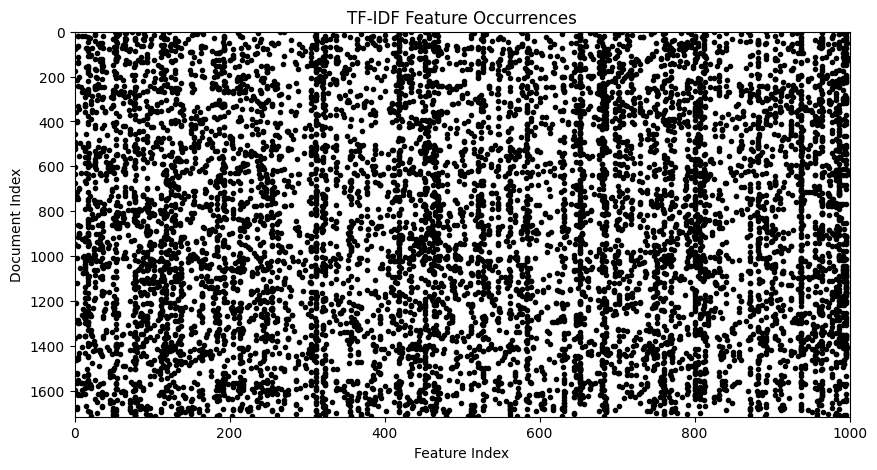

In [368]:
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Assuming 'X' is your sparse matrix
def plot_sparse_matrix(matrix, title="Sparse Matrix"):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))
    # Find non-zero elements
    x, y = matrix.nonzero()
    ax.plot(y, x, 's', color='black', marker='.')
    ax.set(title=title, xlabel='Feature Index', ylabel='Document Index')
    ax.set_xlim([0, matrix.shape[1]])
    ax.set_ylim([0, matrix.shape[0]])
    ax.invert_yaxis()  # Invert y-axis to have the first entry at the top
    plt.show()

plot_sparse_matrix(X, "TF-IDF Feature Occurrences")


In [369]:
def tf_idf(reviews):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Transform the reviews into a TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
    
    # Extract the feature names/terms from the TF-IDF Vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Calculate the average TF-IDF score for each term across all documents
    scores = tfidf_matrix.mean(axis=0)
    term_scores = {feature_names[col]: scores[0, col] for col in range(scores.shape[1])}
    
    # Sort the terms by their average TF-IDF score in descending order
    sorted_term_scores = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Optionally: Display the top 10 terms with the highest average TF-IDF scores
    print("Top 15 terms by average TF-IDF score:")
    for term, score in sorted_term_scores[:15]:
        print(f"Term: {term}, Score: {round(score, 4)}")
    
    # Calculate cosine similarity among the documents using the TF-IDF matrix
    cos_sim_matrix = cosine_similarity(tfidf_matrix)
    
    # return tfidf_matrix, feature_names, cos_sim_matrix

tf_idf(df['Filtered_Review_String'])